## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
# get current directory
curr_dir = os.getcwd()
cal_folder = 'camera_cal'

# prepare object points
nx = 9
ny = 6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

directory = os.path.join(curr_dir, cal_folder)

objpoints = []
imgpoints = []

for file in os.listdir(directory):
    filename = os.path.join(curr_dir, cal_folder, os.fsdecode(file))

    # read the current image into numpy array
    img = cv2.imread(filename)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # if corners found, add them to the list
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


# camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
pickle.dump(mtx,open(os.path.join(curr_dir, "cal_mtx.p"), "wb" ))
pickle.dump(dist,open(os.path.join(curr_dir, "cal_dist.p"), "wb"))

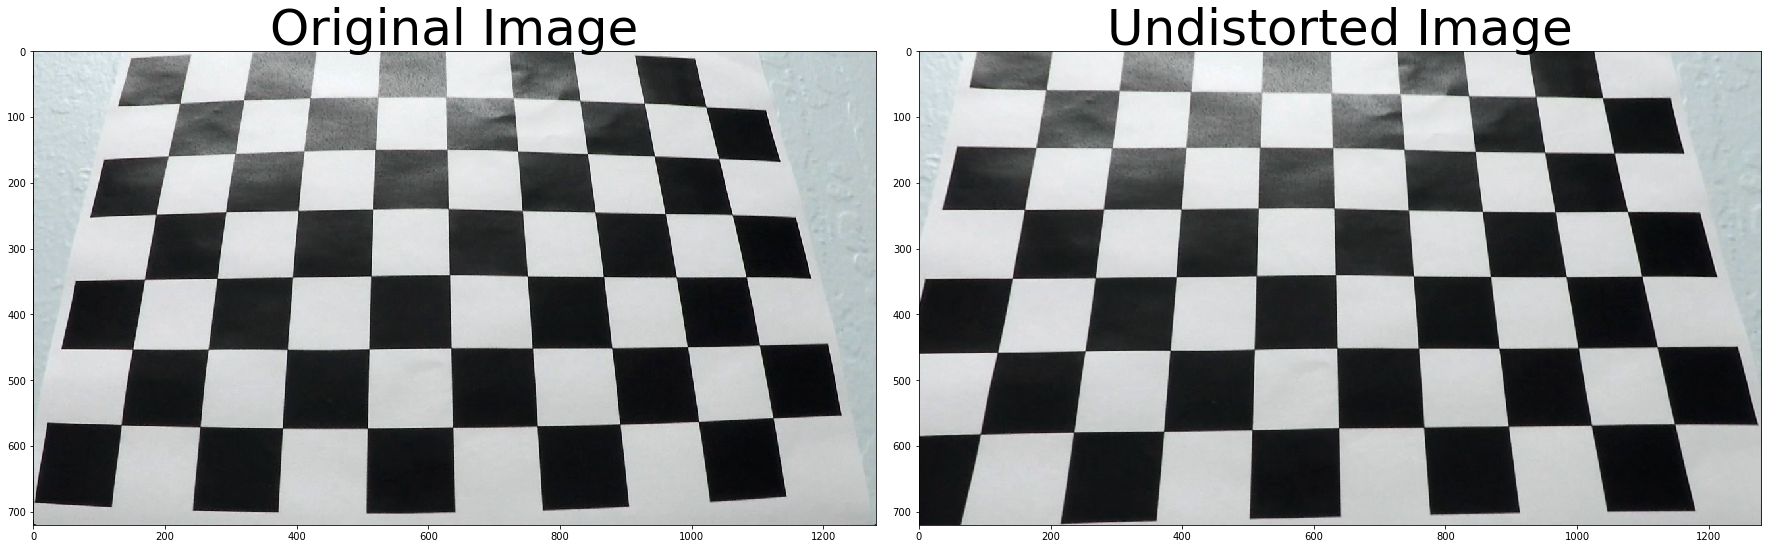

In [4]:
%matplotlib inline

# an example chessboard image from the calibration data
example_file = os.path.join(curr_dir, cal_folder, 'calibration3.jpg')
example_img = cv2.imread(example_file)

#undistort image using calibration parameters
undistorted = cv2.undistort(example_img, mtx, dist, None, mtx)

# plot example undistorted image vs original
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

In [34]:
def change_perspective(img, src_points, dst_points):
    '''
    helper function to create warped images
    '''
    print('gettingPerspectiveTransform')
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    print('warp perspective called')
    warped_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    print('returning warped image')
    return warped_image, M, Minv

gettingPerspectiveTransform
(1280, 720)
warp perspective called
returning warped image


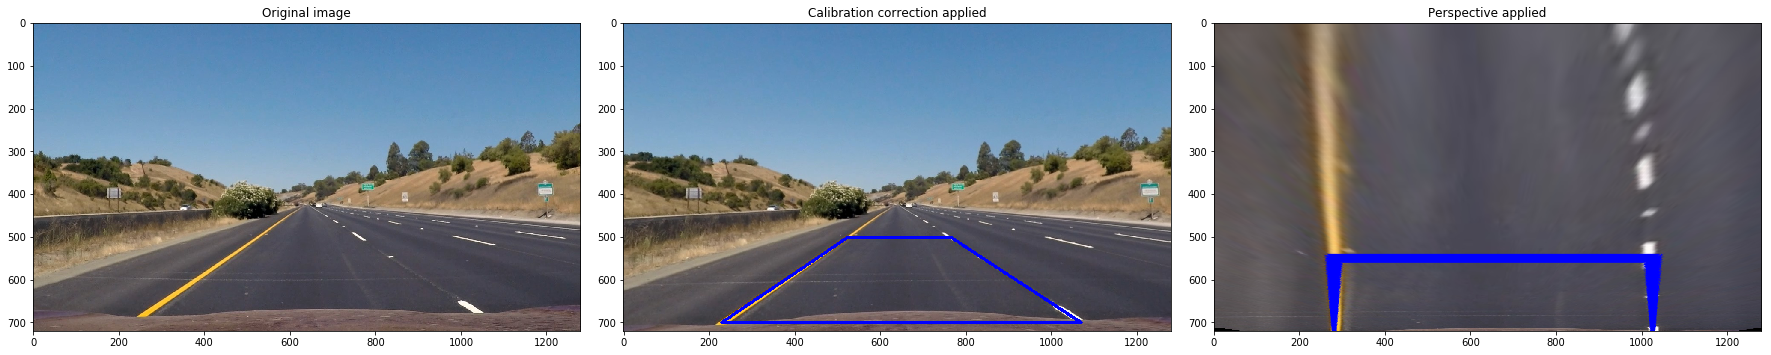

In [136]:
original_image = cv2.imread(os.path.join(curr_dir, 'test_images', 'straight_lines1.jpg'))

undistorted = cv2.undistort(original_image, mtx, dist, None, mtx)

width, height = 1280, 720

bottom_left = [230, 700]
top_left = [525, 500]
top_right = [765, 500]
bottom_right = [1070, 700]

left_offset = 280.0
right_offset = (width - bottom_right[0]) / np.float32(bottom_left[0]) * left_offset
top_offset = 550.0
bottom_offset = 0.0

bottom_left_dst = [left_offset, height - bottom_offset]
top_left_dst = [left_offset, top_offset]
top_right_dst = [width - right_offset, top_offset]
bottom_right_dst = [width - right_offset, height - bottom_offset]

src_p = np.array([bottom_left, top_left, top_right, bottom_right], np.float32)
dst_p = np.array([bottom_left_dst, top_left_dst, top_right_dst, bottom_right_dst], np.float32)

plot_points = np.int32([src_p]) # to draw the polygon for visualizing

cv2.polylines(undistorted, plot_points, True, (255, 0, 0), 5)


changed_perspective, M, Minv = change_perspective(undistorted, src_p, dst_p)

pickle.dump(M, open(os.path.join(curr_dir,"cam_perspective_transform.p"),'wb'))
pickle.dump(Minv, open(os.path.join(curr_dir,"cam_perspective_transform_inv.p"),'wb'))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original image')
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Calibration correction applied')
ax3.imshow(cv2.cvtColor(changed_perspective, cv2.COLOR_BGR2RGB))
ax3.set_title('Perspective applied')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

## Color thresholding

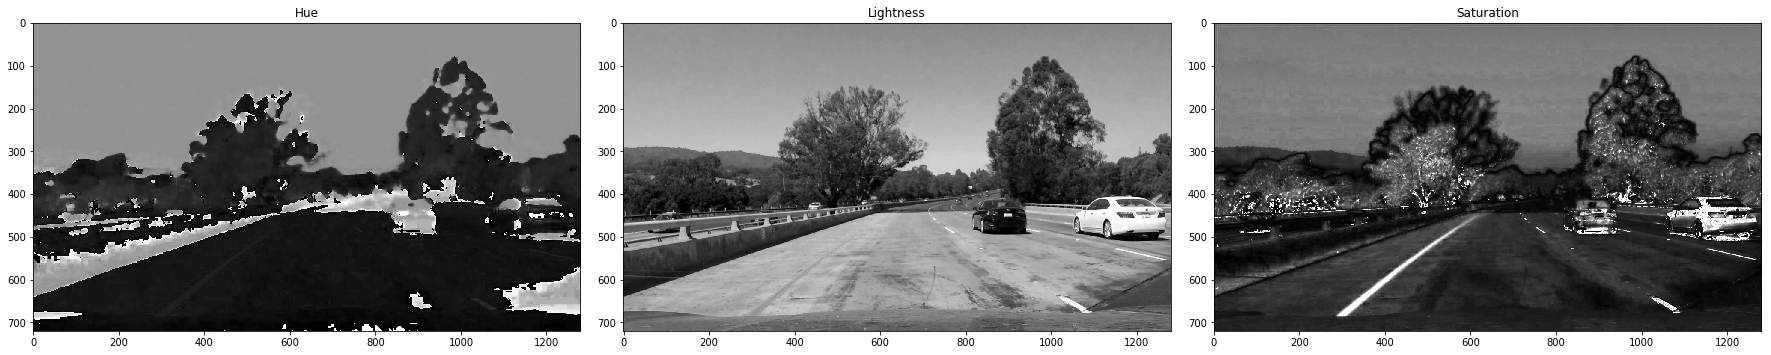

In [6]:
#see the effects of HLS colorspace:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2HLS)[:,:,0],'gray')
ax1.set_title('Hue')
ax2.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2HLS)[:,:,1],'gray')
ax2.set_title('Lightness')
ax3.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2HLS)[:,:,2],'gray')
ax3.set_title('Saturation')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

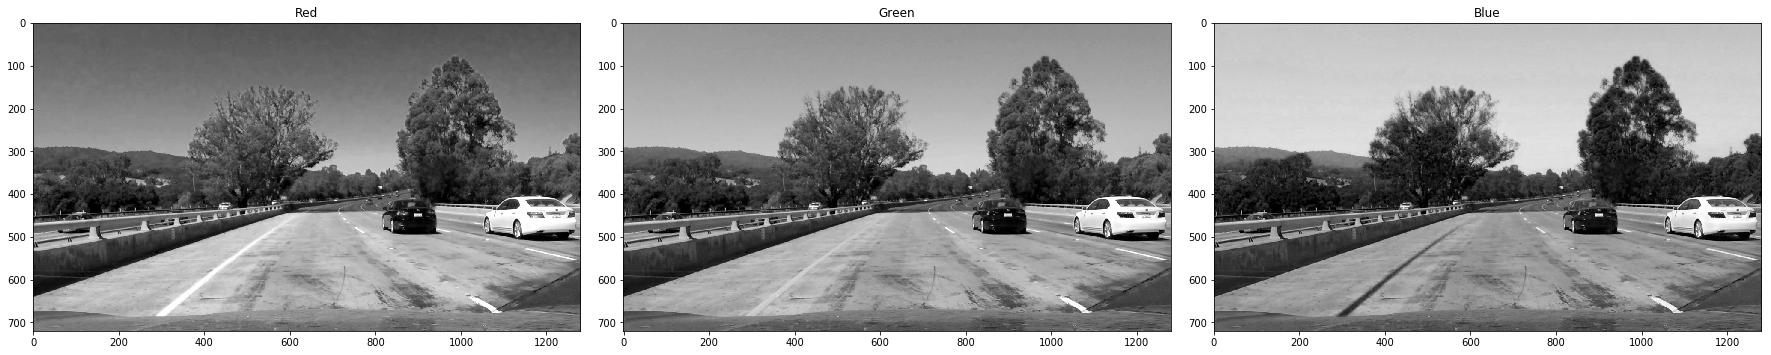

In [7]:
#see the effects of RGB colorspace:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)[:,:,0],'gray')
ax1.set_title('Red')
ax2.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)[:,:,1],'gray')
ax2.set_title('Green')
ax3.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)[:,:,2],'gray')
ax3.set_title('Blue')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

<class 'numpy.ndarray'>


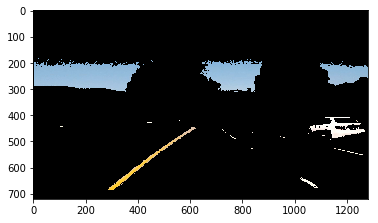

In [38]:
original_image = cv2.cvtColor(cv2.imread(os.path.join(curr_dir, 'test_images', 'test1.jpg')),cv2.COLOR_BGR2RGB)
#code from first project submssion:
yellow_max = np.array([255,255,255],np.uint8)
yellow_min = np.array([0,180,0],np.uint8)
yellow_binary = np.zeros_like(original_image[:,:,0]) 
cv2.inRange(original_image, yellow_min, yellow_max, yellow_binary)

white_min = np.array([150,150,150],np.uint8)
white_max = np.array([250,250,250],np.uint8)
white_binary = np.zeros_like(original_image[:,:,0]) 
cv2.inRange(original_image, white_min, white_max, white_binary)

saturation_min = np.array([0,0,100],np.uint8)
saturation_max = np.array([255,255,255],np.uint8)
sat_binary = np.zeros_like(original_image[:,:,0]) 
cv2.inRange(cv2.cvtColor(original_image,cv2.COLOR_BGR2HLS), 
            saturation_min, saturation_max, sat_binary)
print(type(sat_binary))

color_filter = cv2.bitwise_and(original_image,original_image, 
                               mask = cv2.bitwise_and(
                                   cv2.bitwise_or(yellow_binary ,white_binary),
                                   sat_binary))
plt.imshow(color_filter)


In [123]:
def yellow_mask(img):
    '''function to return masking for yellow lines'''
    yellow_max = np.array([255,255,255],np.uint8)
    yellow_min = np.array([0,180,0],np.uint8)
    yellow_binary = np.zeros_like(img[:,:,0]) 
    cv2.inRange(img, yellow_min, yellow_max, yellow_binary)
    return yellow_binary

def white_mask(img):
    '''function to return masking for white lines'''
    white_min = np.array([150,150,150],np.uint8)
    white_max = np.array([255,255,255],np.uint8)
    white_binary = np.zeros_like(img[:,:,0]) 
    cv2.inRange(img, white_min, white_max, white_binary)
    return white_binary

def hsv_mask(img):
    '''function to return masking for hsv filter'''
    saturation_min = np.array([0,0,100],np.uint8)
    saturation_max = np.array([255,255,255],np.uint8)
    sat_binary = np.zeros_like(img[:,:,0]) 
    cv2.inRange(cv2.cvtColor(img,cv2.COLOR_BGR2HLS), 
            saturation_min, saturation_max, sat_binary)
    return sat_binary


## Helper functions for gradient thresholding from lecture:

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [49]:
class ColorFilter():
    def __init__(self):
        pass
    
    def filter(self, original_image):
        combined = np.zeros_like(original_image[:,:,0],np.uint8)
        yellow_binary = self.yellow_mask(original_image)
        white_binary = self.white_mask(original_image)
        sat_binary = self.hsv_mask(original_image)
        color_filter = cv2.bitwise_and(original_image,original_image, 
                               mask = cv2.bitwise_and(
                                   cv2.bitwise_or(yellow_binary ,white_binary),
                                   sat_binary))
        
        combined[((color_filter[:,:,0] >0 ) | 
                   (color_filter[:,:,1] >0) | 
                   (color_filter[:,:,2] >0)
                         )] = 1

        return np.dstack((combined, combined, combined))*255
    
    def yellow_mask(self, img):
        '''function to return masking for yellow lines'''
        yellow_max = np.array([255,255,255],np.uint8)
        yellow_min = np.array([0,180,0],np.uint8)
        yellow_binary = np.zeros_like(img[:,:,0]) 
        cv2.inRange(img, yellow_min, yellow_max, yellow_binary)
        return yellow_binary

    def white_mask(self, img):
        '''function to return masking for white lines'''
        white_min = np.array([150,150,150],np.uint8)
        white_max = np.array([250,250,250],np.uint8)
        white_binary = np.zeros_like(img[:,:,0]) 
        cv2.inRange(img, white_min, white_max, white_binary)
        return white_binary

    def hsv_mask(self, img):
        '''function to return masking for hsv filter'''
        saturation_min = np.array([0,0,100],np.uint8)
        saturation_max = np.array([255,255,255],np.uint8)
        sat_binary = np.zeros_like(img[:,:,0]) 
        cv2.inRange(cv2.cvtColor(img,cv2.COLOR_BGR2HLS), 
                saturation_min, saturation_max, sat_binary)
        return sat_binary

In [54]:
import pickle
import os
import numpy as np
import cv2

class Lane():
    def __init__(self):
        self.history_A = []
        self.history_B = []
        self.history_C = []
        self.num_lines = 0
        self.MAX_NUM_HISTORY_LINES = 10
        self.lane_inds = []
        self.nwindows = 9
        self.reset = False
    
    def init_plot_points(self, img):
        self.ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        self.xPts = np.zeros_like(self.ploty, np.float32)
        
    def A(self):
        if len(self.history_A) > 0:
            return sum(self.history_A)/self.num_lines
        else:
            return 0
        
    def B(self):
        if len(self.history_B) > 0:
            return sum(self.history_B)/self.num_lines
        else:
            return 0
        
    def C(self):
        if len(self.history_C) > 0:
            return sum(self.history_C)/self.num_lines
        else:
            return 0
    
    def add_line(self, a, b, c):
        if self.num_lines < self.MAX_NUM_HISTORY_LINES:
            self.num_lines += 1
        else:
            del self.history_A[0]
            del self.history_B[0]
            del self.history_C[0]
        self.history_A.append(a)
        self.history_B.append(b)
        self.history_C.append(c)
    
    def update(self, xbase, binary_warped_img):
        window_height = np.int(binary_warped_img.shape[0]/self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = xbase
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 10
        # Create empty lists to receive left and right lane pixel indices
        self.lane_inds = []
        
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y 
            win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
            win_y_high = binary_warped_img.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin


            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
            # Append these indices to the lists
            self.lane_inds.append(good_inds)
            
            # If found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))


        # Concatenate the arrays of indices
        self.lane_inds = np.concatenate(self.lane_inds)
       

        # Extract line pixel positions
        X = nonzerox[self.lane_inds]
        Y = nonzeroy[self.lane_inds] 
         

        # Fit a second order polynomial 
        if len(X) > 2:
            polyline_fit = np.polyfit(Y, X, 2)
            self.add_line(polyline_fit[0], polyline_fit[1], polyline_fit[2])

    def update_using_previous(self, xbase, binary_warped):
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        self.lane_inds = []
        self.lane_inds = ((nonzerox > (self.A()*(nonzeroy**2) + self.B()*nonzeroy + 
                            self.C() - margin)) & (nonzerox < (self.A()*(nonzeroy**2) + 
                            self.B()*nonzeroy + self.C() + margin))) 


        # Again, extract left and right line pixel positions
        X = nonzerox[self.lane_inds]
        Y = nonzeroy[self.lane_inds] 
        
        if len(X) > 2:
            # Fit a second order polynomial to each
            polyline_fit = np.polyfit(Y, X, 2)
       
            # TODO: sanity check here
            self.add_line(polyline_fit[0], polyline_fit[1], polyline_fit[2])
        else:
            self.reset = True
            self.update(xbase, binary_warped)
            self.reset = False
        
    def get_pts(self):
        self.xPts = np.array([(y**2)*self.A() + y*self.B() + self.C() 
                              for y in self.ploty])
        return np.array([np.transpose(np.vstack([self.xPts, self.ploty]))])

In [62]:
class FrameProcessor():
    def __init__(self):
        self.mtx = pickle.load( open( "cal_mtx.p", "rb" ) )
        self.dist = pickle.load( open( "cal_dist.p", "rb" ) )
        self.M = pickle.load(open("cam_perspective_transform.p", "rb"))
        self.Minv = pickle.load(open("cam_perspective_transform_inv.p", "rb"))
        self.color_filter = ColorFilter()
        
        self.left_line = Lane()
        self.right_line = Lane()
        #self.left_line.add_line(0, 0, 280)
        #self.right_line.add_line(0,0, bottom_right_dst[0] )
        
        self.image_size = None
        self.blank_warped = None
        self.color_warped = None
        self.warped = None
        
        self.first_estimation = True
        
    def calculate_line_params(self, unwarped_binary_image):
        self.warped = cv2.warpPerspective(unwarped_binary_image, self.M, self.image_size, flags=cv2.INTER_LINEAR)
        binary_warped = self.warped[:,:,0]
        
        # from lecture notes:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255
    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        if self.first_estimation:
            self.left_line.update(leftx_base, out_img)
            self.right_line.update(rightx_base, out_img)
        else:
            self.left_line.update_using_previous(leftx_base, out_img)
            self.right_line.update_using_previous(rightx_base, out_img)
    
    def process(self, img):
        undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        filtered = self.color_filter.filter(undistorted)
        if self.image_size is None:
            self.image_size = (img.shape[1], img.shape[0])
            self.left_line.init_plot_points(filtered)
            self.right_line.init_plot_points(filtered)
        
        self.calculate_line_params(filtered)
        return self.add_line_annotation(img)
    
    def add_line_annotation(self, img):
        
        if self.blank_warped is None:
            self.blank_warped = np.zeros_like(img[:,:,0],np.uint8)
            self.color_warped = np.dstack((self.blank_warped, self.blank_warped, self.blank_warped))
            
        pts_left = self.left_line.get_pts()
        pts_right = np.fliplr(self.right_line.get_pts())
        print(len(self.left_line.ploty))
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(self.color_warped, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(self.color_warped, self.Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        #result = cv2.addWeighted(self.warped, 1, self.color_warped, 0.3, 0)
        return result

0.00026459979657
-0.366957694209
397.529698796
-----
0.000293463963493
-0.447184235081
1201.54879157


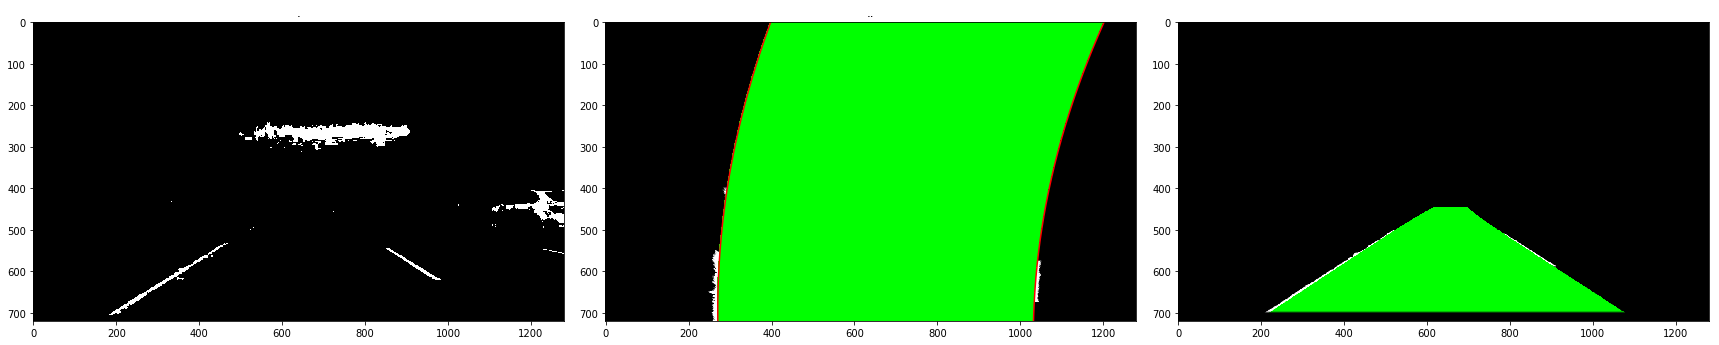

In [63]:
##TESTING THE FrameProcessor ON TEST IMAGES
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
# get current directory
curr_dir = os.getcwd()
%matplotlib inline
curr_dir = os.getcwd()
imgimg = cv2.imread(os.path.join(curr_dir, 'test_images', 'test5.jpg'))
org_img = cv2.cvtColor(imgimg, cv2.COLOR_BGR2RGB)
pp = FrameProcessor()

undist = cv2.undistort(org_img, pp.mtx, pp.dist, None, pp.mtx)
filtered = pp.color_filter.filter(undist)
pp.right_line.init_plot_points(filtered)
pp.left_line.init_plot_points(filtered)
pp.image_size = (org_img.shape[1], org_img.shape[0])
pp.calculate_line_params(filtered)
print(pp.left_line.A())
print(pp.left_line.B())
print(pp.left_line.C())
print('-----')
print(pp.right_line.A())
print(pp.right_line.B())
print(pp.right_line.C())

# Generate x and y values for plotting
ploty = np.linspace(0, pp.warped.shape[0]-1, pp.warped.shape[0] )
left_fitx = pp.left_line.A()*ploty**2 + pp.left_line.B()*ploty + pp.left_line.C()
right_fitx = pp.right_line.A()*ploty**2 + pp.right_line.B()*ploty + pp.right_line.C()

pts_left = pp.left_line.get_pts()
pts_right = np.fliplr(pp.right_line.get_pts())
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(pp.warped, np.int_([pts]), (0,255, 0))

newwarp = cv2.warpPerspective(pp.warped, pp.Minv, (imgimg.shape[1], imgimg.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(filtered, 1, newwarp, 0.3, 0)
        
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(filtered)
ax1.set_title('.')
ax2.imshow(pp.warped)
ax2.plot(left_fitx, ploty, color='red')
ax2.plot(right_fitx, ploty, color='red')
ax2.set_title('..')
ax3.imshow(newwarp)


In [64]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

output = os.path.join(curr_dir,'deneme.mp4')

fp = FrameProcessor()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip(os.path.join(curr_dir,"project_video.mp4"))
clip1 = VideoFileClip(os.path.join(curr_dir,"project_video.mp4")).subclip(0,3)
clip = clip1.fl_image(fp.process) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

720
[MoviePy] >>>> Building video /Users/emresezginalp/CarND-Term1-Starter-Kit/CarND-Advanced-Lane-Lines/deneme.mp4
[MoviePy] Writing video /Users/emresezginalp/CarND-Term1-Starter-Kit/CarND-Advanced-Lane-Lines/deneme.mp4


  0%|          | 0/76 [00:00<?, ?it/s]

720


  3%|▎         | 2/76 [00:00<00:15,  4.82it/s]

720


  4%|▍         | 3/76 [00:00<00:15,  4.69it/s]

720
720

  7%|▋         | 5/76 [00:01<00:14,  4.80it/s]


720
720


  9%|▉         | 7/76 [00:01<00:13,  5.04it/s]

720
720


 12%|█▏        | 9/76 [00:01<00:13,  4.92it/s]

720


 13%|█▎        | 10/76 [00:02<00:14,  4.66it/s]

720


 14%|█▍        | 11/76 [00:02<00:14,  4.48it/s]

720


 16%|█▌        | 12/76 [00:02<00:14,  4.51it/s]

720
720


 18%|█▊        | 14/76 [00:02<00:12,  4.87it/s]

720
720


 21%|██        | 16/76 [00:03<00:11,  5.14it/s]

720


 22%|██▏       | 17/76 [00:03<00:12,  4.81it/s]

720


 24%|██▎       | 18/76 [00:03<00:12,  4.81it/s]

720
720


 26%|██▋       | 20/76 [00:04<00:11,  4.85it/s]

720


 28%|██▊       | 21/76 [00:04<00:11,  4.79it/s]

720
720


 30%|███       | 23/76 [00:04<00:11,  4.69it/s]

720
720


 33%|███▎      | 25/76 [00:05<00:10,  5.03it/s]

720


 34%|███▍      | 26/76 [00:05<00:10,  4.72it/s]

720


 36%|███▌      | 27/76 [00:05<00:10,  4.78it/s]

720
720


 38%|███▊      | 29/76 [00:05<00:09,  5.01it/s]

720


 39%|███▉      | 30/76 [00:06<00:09,  4.80it/s]

720
720

 42%|████▏     | 32/76 [00:06<00:08,  5.01it/s]


720
720


 45%|████▍     | 34/76 [00:06<00:08,  5.01it/s]

720


 46%|████▌     | 35/76 [00:07<00:08,  4.83it/s]

720


 47%|████▋     | 36/76 [00:07<00:08,  4.75it/s]

720


 49%|████▊     | 37/76 [00:07<00:08,  4.72it/s]

720
720


 51%|█████▏    | 39/76 [00:08<00:07,  4.96it/s]

720
720


 54%|█████▍    | 41/76 [00:08<00:06,  5.05it/s]

720


 55%|█████▌    | 42/76 [00:08<00:06,  5.00it/s]

720
720

 59%|█████▉    | 45/76 [00:09<00:05,  5.23it/s]


720
720


 61%|██████    | 46/76 [00:09<00:05,  5.21it/s]

720


 62%|██████▏   | 47/76 [00:09<00:06,  4.34it/s]

720


 63%|██████▎   | 48/76 [00:09<00:06,  4.49it/s]

720


 64%|██████▍   | 49/76 [00:10<00:05,  4.55it/s]

720
720


 67%|██████▋   | 51/76 [00:10<00:05,  4.53it/s]

720


 68%|██████▊   | 52/76 [00:10<00:05,  4.61it/s]

720


 70%|██████▉   | 53/76 [00:11<00:05,  4.26it/s]

720


 71%|███████   | 54/76 [00:11<00:05,  4.29it/s]

720


 72%|███████▏  | 55/76 [00:11<00:04,  4.43it/s]

720


 74%|███████▎  | 56/76 [00:11<00:04,  4.57it/s]

720
720


 76%|███████▋  | 58/76 [00:12<00:04,  4.43it/s]

720
720


 79%|███████▉  | 60/76 [00:12<00:03,  4.76it/s]

720


 80%|████████  | 61/76 [00:12<00:03,  4.73it/s]

720


 82%|████████▏ | 62/76 [00:13<00:03,  4.39it/s]

720


 83%|████████▎ | 63/76 [00:13<00:03,  4.29it/s]

720


 84%|████████▍ | 64/76 [00:13<00:03,  3.87it/s]

720


 86%|████████▌ | 65/76 [00:13<00:02,  3.96it/s]

720
720

 88%|████████▊ | 67/76 [00:14<00:02,  4.36it/s]


720


 89%|████████▉ | 68/76 [00:14<00:01,  4.47it/s]

720


 91%|█████████ | 69/76 [00:14<00:01,  4.56it/s]

720


 92%|█████████▏| 70/76 [00:14<00:01,  4.21it/s]

720


 93%|█████████▎| 71/76 [00:15<00:01,  4.36it/s]

720


 95%|█████████▍| 72/76 [00:15<00:00,  4.18it/s]

720


 96%|█████████▌| 73/76 [00:15<00:00,  4.28it/s]

720


 97%|█████████▋| 74/76 [00:15<00:00,  4.08it/s]

720
720


 99%|█████████▊| 75/76 [00:16<00:00,  4.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/emresezginalp/CarND-Term1-Starter-Kit/CarND-Advanced-Lane-Lines/deneme.mp4 

CPU times: user 17.8 s, sys: 1.39 s, total: 19.2 s
Wall time: 18.4 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="deneme.mp4">
</video>
""")